# Train and deploy a Machine Learning model in the cloud using Azure Machine Learning services

This script explains how to train a model in the cloud and deploy it as a web service. This allows to call your model in external applications such as, for instance, a web page.

Azure Machine Learning is a all-in-one service for a machine learning pipeline. It allows to scale up and automate: model management, model training, model selection, hyperparameter tuning, model evaluation and deployment.

This tutorial trains a simple logistic regression on the MNIST dataset using the famous scikit-learn library. The tutorial is partially based on this [page](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-train-models-with-aml).

To train and deploy a model on Azure ML services, we are going to follow these steps:
- Train a model locally 
- Create a workspace on Azure Machine Learning services
- Create an experiment in the workspace

### Create a Workspace
First of all, we need the Azure ML SDK and required libraries (scikit-learn, matplotlib and tqdm) installed locally. Follow this [link](https://docs.microsoft.com/en-gb/python/api/overview/azure/ml/install?view=azure-ml-py) for the installation. The following cell should then print your azureml sdk version.

In [1]:
import azureml.core

print("This notebook was created using version 1.0.57 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.0.57 of the Azure ML SDK
You are currently using version 1.0.57 of the Azure ML SDK


Create a new workspace using the follwing cell

In [2]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = "test_workspace",
                      subscription_id = "0b17ea40-18b3-49cc-9bad-315dc6e333b1",
                      resource_group = "test_rg", 
                      location = "eastus2",
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Deploying KeyVault with name testworkkeyvaultab74973e.
Deploying StorageAccount with name testworkstorage9c4febf3f.
Deployed KeyVault with name testworkkeyvaultab74973e. Took 26.0 seconds.
Deployed StorageAccount with name testworkstorage9c4febf3f. Took 26.59 seconds.
Deploying AppInsights with name testworkinsightsa4a84acf.
Deployed AppInsights with name testworkinsightsa4a84acf. Took 32.04 seconds.
Deploying Workspace with name test_workspace.
Deployed Workspace with name test_workspace. Took 25.09 seconds.


Connect to the workspace

In [3]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

test_workspace	eastus2	test_rg


### Create an experiment

In [4]:
from azureml.core import Experiment
experiment_name = 'sklearn-mnist'

exp = Experiment(workspace=ws, name=experiment_name)

### Create a compute target

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-08-29T13:06:20.925000+00:00', 'errors': None, 'creationTime': '2019-08-29T13:06:18.309519+00:00', 'modifiedTime': '2019-08-29T13:06:34.645876+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


### Import packages

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Download the MNIST dataset

In [7]:
import urllib.request
import os

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'test-labels.gz'))

('C:\\Users\\a.nogue.sanchez\\OneDrive - Avanade\\Documents\\Projects\\Projets internes Avanade\\Tribu Analytics\\Machine Learning in Power BI\\Azure ML train and deploy\\data\\test-labels.gz',
 <http.client.HTTPMessage at 0x2318e34fbe0>)

### Explore the data
The following cell prints 30 pictures from the data

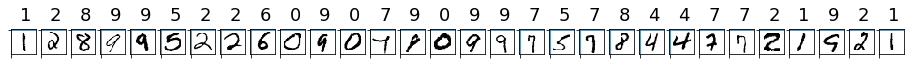

In [8]:
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(
    data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(
    data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(
    data_folder, 'test-labels.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

### Upload the data to the cloud

In [9]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir=data_folder, target_path='mnist',
          overwrite=True, show_progress=True)

AzureBlob testworkstorage9c4febf3f azureml-blobstore-9d18011b-347c-4203-9b78-04c55b51fc37
Uploading an estimated of 4 files
Uploading C:\Users\a.nogue.sanchez\OneDrive - Avanade\Documents\Projects\Projets internes Avanade\Tribu Analytics\Machine Learning in Power BI\Azure ML train and deploy\data\test-images.gz
Uploading C:\Users\a.nogue.sanchez\OneDrive - Avanade\Documents\Projects\Projets internes Avanade\Tribu Analytics\Machine Learning in Power BI\Azure ML train and deploy\data\test-labels.gz
Uploading C:\Users\a.nogue.sanchez\OneDrive - Avanade\Documents\Projects\Projets internes Avanade\Tribu Analytics\Machine Learning in Power BI\Azure ML train and deploy\data\train-images.gz
Uploading C:\Users\a.nogue.sanchez\OneDrive - Avanade\Documents\Projects\Projets internes Avanade\Tribu Analytics\Machine Learning in Power BI\Azure ML train and deploy\data\train-labels.gz
Uploaded C:\Users\a.nogue.sanchez\OneDrive - Avanade\Documents\Projects\Projets internes Avanade\Tribu Analytics\Machi

$AZUREML_DATAREFERENCE_db8d3eeec4b247d980a8572731d919e2

## Train a model on a remote cluster

For this task, submit the job to the remote training cluster you set up earlier. To submit a job you must create a directory, create a training script, an estimator object and submit the job.

### Create a local directory
Create a directory to deliver the necessary code from your computer to the remote resource.

In [10]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

In [11]:
os.chdir(script_folder)

### Create a training script
The following cell creates a file _train.py_ in the directory we just created.

The model consists on a simple Logistic Regression.

In [12]:
%%writefile train.py

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Overwriting train.py


In [13]:
# Copy the utils.py file in the folder just created
os.chdir("..\\")
import shutil
shutil.copy('utils.py', script_folder)

'C:\\Users\\a.nogue.sanchez\\OneDrive - Avanade\\Documents\\Projects\\Projets internes Avanade\\Tribu Analytics\\Machine Learning in Power BI\\Azure ML train and deploy\\sklearn-mnist\\utils.py'

### Create an estimator
An estimator is an object used to submit the run.

In [14]:
from azureml.train.sklearn import SKLearn

script_params = {
    '--data-folder': ds.path('mnist').as_mount(),
    '--regularization': 0.5
}

est = SKLearn(source_directory=script_folder,
              script_params=script_params,
              compute_target=compute_target,
              entry_script='train.py')

### Submit the job to the cluster
The following cell submits the job we just created and launches it. The job takes around 10 minutes to run.

In [15]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1567084019_5f308eae,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


Once the job has been executed (check on the Azure Portal), we can check the results with the following cell.

In [16]:
print(run.get_metrics())

{}


### Register the model
As you can see in the following cell, the _train.py_ script created the model in the outputs folder.

We are now going to register the model in the workspace, so that it can be queryied, examined or deployed by you or other collaborators.

In [17]:
print(run.get_file_names())

[]


In [18]:
# register model
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

ModelPathNotFoundException: ModelPathNotFoundException:
	Message: Could not locate the provided model_path outputs/sklearn_mnist_model.pkl in the set of files uploaded to the run: []
                See https://aka.ms/run-logging for more details.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Could not locate the provided model_path outputs/sklearn_mnist_model.pkl in the set of files uploaded to the run: []\n                See https://aka.ms/run-logging for more details."
    }
}

### Clean up the environment

To not incur into further costs, one should delete the Ressource group from the Azure portal and the Compute target using the following command.

In [ ]:
# optionally, delete the Azure Machine Learning Compute cluster
compute_target.delete()